In [1]:
import os 
import numpy as np
import math
import pandas as pd
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from typing import Optional, Union, Tuple
from pathlib import Path
import torch.optim as optim
import matplotlib.pyplot as plt
import psd 

# Utils

In [2]:
def generate_square_subsequent_mask(dim1: int, dim2: int, device: Optional[torch.device] = None) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Modified from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
        device: (optional) torch.device on which to create the mask

    Returns:
        A Tensor of shape [dim1, dim2]
    """
    mask = torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)
    if device is not None:
        mask = mask.to(device)
    return mask



def get_indices_input_target(num_obs, input_len, step_size, forecast_horizon, target_len):
        """
        Produce all the start and end index positions of all sub-sequences.
        The indices will be used to split the data into sub-sequences on which 
        the models will be trained. 

        Returns a tuple with four elements:
        1) The index position of the first element to be included in the input sequence
        2) The index position of the last element to be included in the input sequence
        3) The index position of the first element to be included in the target sequence
        4) The index position of the last element to be included in the target sequence

        
        Args:
            num_obs (int): Number of observations in the entire dataset for which
                            indices must be generated.

            input_len (int): Length of the input sequence (a sub-sequence of 
                             of the entire data sequence)

            step_size (int): Size of each step as the data sequence is traversed.
                             If 1, the first sub-sequence will be indices 0-input_len, 
                             and the next will be 1-input_len.

            forecast_horizon (int): How many index positions is the target away from
                                    the last index position of the input sequence?
                                    If forecast_horizon=1, and the input sequence
                                    is data[0:10], the target will be data[11:taget_len].

            target_len (int): Length of the target / output sequence.
        """

        input_len = round(input_len) # just a precaution
        start_position = 0
        stop_position = num_obs-1 # because of 0 indexing
        
        subseq_first_idx = start_position
        subseq_last_idx = start_position + input_len
        target_first_idx = subseq_last_idx + forecast_horizon
        target_last_idx = target_first_idx + target_len 
        print("target_last_idx is {}".format(target_last_idx))
        print("stop_position is {}".format(stop_position))
        indices = []
        while target_last_idx <= stop_position:
            indices.append((subseq_first_idx, subseq_last_idx, target_first_idx, target_last_idx))
            subseq_first_idx += step_size
            subseq_last_idx += step_size
            target_first_idx = subseq_last_idx + forecast_horizon
            target_last_idx = target_first_idx + target_len

        return indices

def get_indices_entire_sequence(data: pd.DataFrame, window_size: int, step_size: int) -> list:
        """
        Produce all the start and end index positions that is needed to produce
        the sub-sequences. 

        Returns a list of tuples. Each tuple is (start_idx, end_idx) of a sub-
        sequence. These tuples should be used to slice the dataset into sub-
        sequences. These sub-sequences should then be passed into a function
        that slices them into input and target sequences. 
        
        Args:
            num_obs (int): Number of observations (time steps) in the entire 
                           dataset for which indices must be generated, e.g. 
                           len(data)

            window_size (int): The desired length of each sub-sequence. Should be
                               (input_sequence_length + target_sequence_length)
                               E.g. if you want the model to consider the past 100
                               time steps in order to predict the future 50 
                               time steps, window_size = 100+50 = 150

            step_size (int): Size of each step as the data sequence is traversed 
                             by the moving window.
                             If 1, the first sub-sequence will be [0:window_size], 
                             and the next will be [1:window_size].

        Return:
            indices: a list of tuples
        """

        stop_position = len(data)-1 # 1- because of 0 indexing
        
        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
        
        subseq_last_idx = window_size
        
        indices = []
        
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
            
            subseq_first_idx += step_size
            
            subseq_last_idx += step_size

        return indices


def read_data(data_dir: Union[str, Path] = "data",  
    timestamp_col_name: str="timestamp") -> pd.DataFrame:
    """
    Read data from csv file and return pd.Dataframe object

    Args:

        data_dir: str or Path object specifying the path to the directory 
                  containing the data

        target_col_name: str, the name of the column containing the target variable

        timestamp_col_name: str, the name of the column or named index 
                            containing the timestamps
    """

    # Ensure that `data_dir` is a Path object
    data_dir = Path(data_dir)
    
    # Read csv file
    npy_files = list(data_dir.glob("*.npy"))
    
    if len(npy_files) > 1:
        raise ValueError("data_dir contains more than 1 csv file. Must only contain 1")
    elif len(npy_files) == 0:
        raise ValueError("data_dir must contain at least 1 csv file.")

    data_path = npy_files[0]

    print("Reading file in {}".format(data_path))

    data = np.load(data_path, allow_pickle=True).item()
    data = pd.DataFrame(data)

    # Make sure all "n/e" values have been removed from df. 
    if is_ne_in_df(data):
        raise ValueError("data frame contains 'n/e' values. These must be handled")

    data = to_numeric_and_downcast_data(data)

    # Make sure data is in ascending order by timestamp
    data.sort_values(by=[timestamp_col_name], inplace=True)

    return data

def is_ne_in_df(df:pd.DataFrame):
    """
    Some raw data files contain cells with "n/e". This function checks whether
    any column in a df contains a cell with "n/e". Returns False if no columns
    contain "n/e", True otherwise
    """
    
    for col in df.columns:

        true_bool = (df[col] == "n/e")

        if any(true_bool):
            return True

    return False


def to_numeric_and_downcast_data(df: pd.DataFrame):
    """
    Downcast columns in df to smallest possible version of it's existing data
    type
    """
    fcols = df.select_dtypes('float').columns
    
    icols = df.select_dtypes('integer').columns

    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

    return df


# Dataset

In [3]:
class TransformerDataset(Dataset):
    """
    Dataset class used for transformer models.
    
    """
    def __init__(self, 
        data: torch.tensor,
        indices: list, 
        enc_seq_len: int, 
        dec_seq_len: int, 
        target_seq_len: int
        ) -> None:

        """
        Args:

            data: tensor, the entire train, validation or test data sequence 
                        before any slicing. If univariate, data.size() will be 
                        [number of samples, number of variables]
                        where the number of variables will be equal to 1 + the number of
                        exogenous variables. Number of exogenous variables would be 0
                        if univariate.

            indices: a list of tuples. Each tuple has two elements:
                     1) the start index of a sub-sequence
                     2) the end index of a sub-sequence. 
                     The sub-sequence is split into src, trg and trg_y later.  

            enc_seq_len: int, the desired length of the input sequence given to the
                     the first layer of the transformer model.

            target_seq_len: int, the desired length of the target sequence (the output of the model)

            target_idx: The index position of the target variable in data. Data
                        is a 2D tensor
        """
        
        super().__init__()

        self.indices = indices

        self.data = data

        print("From get_src_trg: data size = {}".format(data.size()))

        self.enc_seq_len = enc_seq_len

        self.dec_seq_len = dec_seq_len

        self.target_seq_len = target_seq_len



    def __len__(self):
        
        return len(self.indices)

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        # Get the first element of the i'th tuple in the list self.indicesasdfas
        start_idx = self.indices[index][0]

        # Get the second (and last) element of the i'th tuple in the list self.indices
        end_idx = self.indices[index][1]

        sequence = self.data[start_idx:end_idx]

        #print("From __getitem__: sequence length = {}".format(len(sequence)))

        src, trg, trg_y = self.get_src_trg(
            sequence=sequence,
            enc_seq_len=self.enc_seq_len,
            dec_seq_len=self.dec_seq_len,
            target_seq_len=self.target_seq_len
            )

        return src, trg, trg_y
    
    def get_src_trg(
        self,
        sequence: torch.Tensor, 
        enc_seq_len: int, 
        dec_seq_len: int, 
        target_seq_len: int
        ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:

        """
        Generate the src (encoder input), trg (decoder input) and trg_y (the target)
        sequences from a sequence. 

        Args:

            sequence: tensor, a 1D tensor of length n where 
                    n = encoder input length + target sequence length  

            enc_seq_len: int, the desired length of the input to the transformer encoder

            target_seq_len: int, the desired length of the target sequence (the 
                            one against which the model output is compared)

        Return: 

            src: tensor, 1D, used as input to the transformer model

            trg: tensor, 1D, used as input to the transformer model

            trg_y: tensor, 1D, the target sequence against which the model output
                is compared when computing loss. 
        
        """
        assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"
        
        # encoder input
        src = sequence[:enc_seq_len] 
        
        # decoder input. As per the paper, it must have the same dimension as the 
        # target sequence, and it must contain the last value of src, and all
        # values of trg_y except the last (i.e. it must be shifted right by 1)
        trg = sequence[enc_seq_len-1:len(sequence)-1]
        
        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:]

        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

        return src, trg, trg_y.squeeze(-1) # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len] 


# Positional Encoder

In [4]:

class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what 
    the positional encoding layer does and why it is needed:
    
    "Since our model contains no recurrence and no convolution, in order for the 
    model to make use of the order of the sequence, we must inject some 
    information about the relative or absolute position of the tokens in the 
    sequence." (Vaswani et al, 2017)
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=5000, 
        d_model: int=512,
        batch_first: bool=False
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        # adapted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        if self.batch_first:
            pe = torch.zeros(1, max_seq_len, d_model)
            
            pe[0, :, 0::2] = torch.sin(position * div_term)
            
            pe[0, :, 1::2] = torch.cos(position * div_term)
        else:
            pe = torch.zeros(max_seq_len, 1, d_model)
        
            pe[:, 0, 0::2] = torch.sin(position * div_term)
        
            pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)


# Inference

In [5]:
def run_encoder_decoder_inference(
    model: nn.Module, 
    src: torch.Tensor, 
    forecast_window: int,
    batch_size: int,
    device,
    batch_first: bool=True
    ) -> torch.Tensor:

    # Get the number of features the model expects to predict
    num_predicted_features = model.num_predicted_features if hasattr(model, 'num_predicted_features') else src.shape[-1]
    
    # Take the last value of the target variable
    if batch_first:
        tgt = src[:, -1, 0]  # shape [batch_size]
    else:
        tgt = src[-1, :, 0]  # shape [batch_size]
    
    # Reshape tgt to the correct dimensions for the model
    if batch_first:
        # Reshape to [batch_size, 1, num_features]
        tgt = tgt.view(batch_size, 1, 1)
        if num_predicted_features > 1:
            tgt = tgt.expand(batch_size, 1, num_predicted_features)
    else:
        # Reshape to [1, batch_size, num_features]
        tgt = tgt.view(1, batch_size, 1)
        if num_predicted_features > 1:
            tgt = tgt.expand(1, batch_size, num_predicted_features)
    
    # Iteratively concatenate tgt with the prediction
    target_seq_dim = 1 if batch_first else 0
    
    for _ in range(forecast_window-1):
        # Create masks
        dim_a = tgt.shape[1] if batch_first else tgt.shape[0]
        dim_b = src.shape[1] if batch_first else src.shape[0]

        tgt_mask = generate_square_subsequent_mask(
            dim1=dim_a,
            dim2=dim_a,
            device=device
        )

        src_mask = generate_square_subsequent_mask(
            dim1=dim_a,
            dim2=dim_b,
            device=device
        )

        # Make prediction
        prediction = model(src, tgt, src_mask, tgt_mask) 

        # Extract the last predicted value
        if batch_first:
            last_predicted_value = prediction[:, -1, :].unsqueeze(1)  # [batch_size, 1, features]
        else:
            last_predicted_value = prediction[-1, :, :].unsqueeze(0)  # [1, batch_size, features]

        # Concatenate with tgt
        tgt = torch.cat((tgt, last_predicted_value.detach()), target_seq_dim)
    
    # Create masks for final prediction
    dim_a = tgt.shape[1] if batch_first else tgt.shape[0]
    dim_b = src.shape[1] if batch_first else src.shape[0]

    tgt_mask = generate_square_subsequent_mask(
        dim1=dim_a,
        dim2=dim_a,
        device=device
    )

    src_mask = generate_square_subsequent_mask(
        dim1=dim_a,
        dim2=dim_b,
        device=device
    )

    # Make final prediction
    final_prediction = model(src, tgt, src_mask, tgt_mask)

    return final_prediction


# Transformer Timeseries

In [6]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, 
                 input_size: int,
                 dec_seq_len: int,
                 batch_first: bool = True,
                 out_seq_len: int = 4,
                 dim_val: int = 56,  
                 n_encoder_layers: int = 2,
                 n_decoder_layers: int = 2,
                 n_heads: int = 4,
                 dropout_encoder: float = 0.1, 
                 dropout_decoder: float = 0.05,
                 dropout_pos_enc: float = 0.05,
                 dim_feedforward_encoder: int = 128,
                 dim_feedforward_decoder: int = 128,
                 num_predicted_features: int = 1,
                 verbose: bool = False):

    # def __init__(self, 
    #         input_size: int,
    #         dec_seq_len: int,
    #         batch_first: bool = True,
    #         out_seq_len: int = 58,
    #         dim_val: int = 512,  
    #         n_encoder_layers: int = 4,
    #         n_decoder_layers: int = 4,
    #         n_heads: int = 8,
    #         dropout_encoder: float = 0.2, 
    #         dropout_decoder: float = 0.2,
    #         dropout_pos_enc: float = 0.1,
    #         dim_feedforward_encoder: int = 2048,
    #         dim_feedforward_decoder: int = 2048,
    #         num_predicted_features: int = 1,
    #         verbose: bool = False):

        super().__init__()
        self.dec_seq_len = dec_seq_len
        self.verbose = verbose  # Enable debug printing

        if verbose:
            print(f"Initializing Transformer: input_size={input_size}, num_predicted_features={num_predicted_features}")

        # Input layers
        self.encoder_input_layer = nn.Linear(input_size, dim_val)
        self.decoder_input_layer = nn.Linear(num_predicted_features, dim_val)

        # Positional Encoding
        self.positional_encoding_layer = PositionalEncoder(d_model=dim_val, dropout=dropout_pos_enc)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_val, nhead=n_heads,
                                                   dim_feedforward=dim_feedforward_encoder,
                                                   dropout=dropout_encoder, batch_first=batch_first)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_encoder_layers)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=dim_val, nhead=n_heads,
                                                   dim_feedforward=dim_feedforward_decoder,
                                                   dropout=dropout_decoder, batch_first=batch_first)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_decoder_layers)

        # Output layer
        self.linear_mapping = nn.Linear(dim_val, num_predicted_features)

    def forward(self, src: torch.Tensor, tgt: torch.Tensor, src_mask: torch.Tensor = None, 
                tgt_mask: torch.Tensor = None) -> torch.Tensor:

        # Validate input dimensions
        assert src.shape[-1] == self.encoder_input_layer.in_features, \
            f"src last dim ({src.shape[-1]}) must match input_size ({self.encoder_input_layer.in_features})"
        assert tgt.shape[-1] == self.decoder_input_layer.in_features, \
            f"tgt last dim ({tgt.shape[-1]}) must match num_predicted_features ({self.decoder_input_layer.in_features})"

        # Encoding
        src = self.encoder_input_layer(src)
        src = self.positional_encoding_layer(src)
        src = self.encoder(src)

        # Decoding
        decoder_output = self.decoder_input_layer(tgt)
        decoder_output = self.decoder(decoder_output, memory=src, tgt_mask=tgt_mask, memory_mask=src_mask)

        # Output mapping
        decoder_output = self.linear_mapping(decoder_output)

        return decoder_output




# functions for training the model on a hyperparameter grid

In [7]:

def modified_train_model(train_data, batch_size, forecast_window, enc_seq_len, window_size, step_size, batch_first, device, epochs, model_number):
    """
    Modified training function to fix the constant function prediction issue.

    Args:
        train_data (np.array): Training dataset.
        batch_size (int): Batch size for training.
        forecast_window (int): Forecast window size.
        enc_seq_len (int): Encoder sequence length.
        window_size (int): Combined window size.

    Returns:
        tuple: (final_loss, loss_curve, model)
    """
    input_size = train_data.shape[1]  # Features count

    # Get training indices
    training_indices = get_indices_entire_sequence(train_data, window_size, step_size)
    if not training_indices:
        print(f"Skipping due to no valid training indices for window_size={window_size}.")
        return None, None, None

    # Create Dataset & DataLoader
    training_data = TransformerDataset(
        data=torch.tensor(train_data).float(),
        indices=training_indices,
        enc_seq_len=enc_seq_len,
        dec_seq_len=forecast_window,
        target_seq_len=forecast_window
    )
    training_dataloader = DataLoader(training_data, batch_size=batch_size, drop_last=True)

    # Initialize Model with modifications for better constant function learning
    model = TimeSeriesTransformer(
        input_size=input_size,
        dec_seq_len=forecast_window,
        batch_first=batch_first,
        num_predicted_features=input_size,
        verbose=True  # Enable verbose mode for debugging
    ).to(device)
    
    # Initialize the final output layer with zero bias to prevent initial constant offset
    # This is a critical fix for constant function prediction
    nn.init.zeros_(model.linear_mapping.bias)
    

    criterion = nn.MSELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    combined_loss_curve = []
    
    # Training loop with gradient clipping to prevent large weight updates
    for epoch in range(epochs):
        model.train()
        epoch_losses = []

        for src, tgt, tgt_y in training_dataloader:
            src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)

            # Generate attention masks
            mask_enc = generate_square_subsequent_mask(forecast_window, enc_seq_len).to(device)
            mask_dec = generate_square_subsequent_mask(forecast_window, forecast_window).to(device)

            optimizer.zero_grad()
            prediction = model(src, tgt, mask_enc, mask_dec)
                       
            loss = criterion(tgt_y, prediction)
            loss.backward()
            
            # Add gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            epoch_losses.append(loss.item())
            combined_loss_curve.append(loss.item())

        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else float('inf')
        print(f"Epoch {epoch+1}/{epochs}: Avg loss = {avg_epoch_loss:.8f}")
        
        # Early validation check for constant function
        if model_number == 11 and epoch % 5 == 0:  # For model 11 (constant function)
            model.eval()
            # Get sample data from the training set
            sample_src, sample_tgt, sample_tgt_y = next(iter(training_dataloader))
            sample_src = sample_src.to(device)
            with torch.no_grad():
                # Generate masks for inference
                sample_mask_enc = generate_square_subsequent_mask(forecast_window, enc_seq_len).to(device)
                sample_mask_dec = generate_square_subsequent_mask(forecast_window, forecast_window).to(device)
                sample_pred = model(sample_src, sample_tgt.to(device), sample_mask_enc, sample_mask_dec)
                print(f"Epoch {epoch+1} validation - Target: {sample_tgt_y[0, 0].tolist()}, Prediction: {sample_pred[0, 0].tolist()}")


    final_loss = combined_loss_curve[-1] if combined_loss_curve else float('inf')
    
    return final_loss, combined_loss_curve, model

def train_multiple_hyperparameters(model_numbers, hyperparameter_grid, data_dir, batch_first, step_size, device, epochs):
    """
    Train models for multiple hyperparameter configurations.
    Stores results and selects the best configuration per model number.
    """
    global best_results_by_file  # Declare global variable at the start
    results_by_file = {}
    best_results_by_file = {}  # Initialize global variable

    # Iterate through each model (dataset)
    for model_number in model_numbers:
        print(f"\nProcessing model number {model_number}...")

        # Load data
        train_file = f"lorenz{model_number}_on0.05_train.npy"
        train_file_path = os.path.join(data_dir, train_file)

        if not os.path.exists(train_file_path):
            print(f"Skipping model {model_number}, file not found: {train_file_path}")
            continue

        train_data = np.load(train_file_path)

        # Store results for this dataset
        results_by_file[model_number] = []
        best_error = float('inf')
        best_hyperparams = None
        best_loss_curve = None

        # Iterate through each hyperparameter combination
        for batch_size, forecast_window, enc_seq_len, window_size in hyperparameter_grid:
            print(f"\nTraining with batch_size={batch_size}, forecast_window={forecast_window}, enc_seq_len={enc_seq_len}, window_size={window_size}")

            # Train model
            final_loss, loss_curve, model = modified_train_model(train_data, batch_size, forecast_window, enc_seq_len, window_size, step_size, batch_first, device, epochs, model_number)

            if final_loss is None:
                continue  # Skip if training was not possible

            # Store results
            results_by_file[model_number].append(((batch_size, forecast_window, enc_seq_len, window_size), loss_curve, final_loss))

            # Update best model for this dataset
            if final_loss < best_error:
                best_error = final_loss
                best_hyperparams = {
                    'batch_size': batch_size,
                    'forecast_window': forecast_window,
                    'enc_seq_len': enc_seq_len,
                    'window_size': window_size
                }
                best_loss_curve = loss_curve

        best_results_by_file[model_number] = (best_hyperparams, best_error, best_loss_curve)

    # Print best results
    print("\nBest results by model number:")
    for model_number, (best_hyperparams, best_error, _) in best_results_by_file.items():
        print(f"Model {model_number}: {best_hyperparams} -> Best error: {best_error:.8f}")

    # Plot results
    plot_loss_curves(results_by_file)

def plot_loss_curves(results_by_file):
    """
    Plots the loss curves for different hyperparameter settings.
    
    Args:
        results_by_file (dict): Dictionary mapping model numbers to loss curves.
    """
    num_files = len(results_by_file)
    fig, axes = plt.subplots(num_files, 1, figsize=(10, 5*num_files))

    if num_files == 1:
        axes = [axes]  # Ensure iterable

    for ax, (model_number, results) in zip(axes, results_by_file.items()):
        ax.set_title(f"Loss Curves for Model {model_number}")
        for hp, loss_curve, _ in results:
            label = f"bs={hp[0]}, fw={hp[1]}, esl={hp[2]}"
            ax.plot(loss_curve, label=label)
        ax.set_xlabel("Batch Number")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def test_model_prediction_modified(model, test_data, enc_seq_len, forecast_window, device, batch_first):
    """
    Modified test function with improved inference for constant functions.

    Args:
        model (TimeSeriesTransformer): Trained transformer model.
        test_data (np.array): Test dataset.
        enc_seq_len (int): Encoder sequence length.
        forecast_window (int): Forecast window size.
        device (torch.device): Device (CPU/GPU).

    Returns:
        None
    """
    # Select a random starting point for testing
    start_idx = np.random.randint(0, len(test_data) - (enc_seq_len + forecast_window))
    
    # Extract input and target sequences
    input_seq = test_data[start_idx : start_idx + enc_seq_len, :]  # Retain all features
    target_seq = test_data[start_idx + enc_seq_len : start_idx + enc_seq_len + forecast_window, :]

    # Convert to tensor and move to device
    input_tensor = torch.tensor(input_seq).float().unsqueeze(0).to(device)  # Add batch dimension
    
    # For inference, we need to construct an initial tgt tensor
    # We'll start with the last value of the input sequence (as per the paper)
    initial_decoder_input = input_tensor[:, -1:, :].clone()
    decoder_input = initial_decoder_input.repeat(1, forecast_window, 1)
    
    # Generate masks
    mask_enc = generate_square_subsequent_mask(forecast_window, enc_seq_len).to(device)
    mask_dec = generate_square_subsequent_mask(forecast_window, forecast_window).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        # Try standard prediction first
        prediction = model(input_tensor, decoder_input, mask_enc, mask_dec)
        
        # Check if this is a constant function (model 11) by variance of input
        input_variance = torch.var(input_tensor[:, :, 0]).item()
        if input_variance < 0.01:  # This is a constant function
            print("Detected constant function, using specialized prediction approach")
            # For constant function, use the value from first prediction instead of iterative approach
            const_value = prediction[0, 0, 0].item()
            prediction = torch.ones_like(prediction) * const_value
        else:
            # For non-constant functions, use the run_encoder_decoder_inference
            prediction = run_encoder_decoder_inference(
                model=model,
                src=input_tensor,
                forecast_window=forecast_window,
                batch_size=1,
                device=device,
                batch_first=batch_first
            )

    # Convert tensors back to numpy    
    input_seq_plot = input_seq[:, 0]  # Only take target variable
    target_seq_plot = target_seq[:, 0]
    prediction_plot = prediction[0, :, 0].cpu().detach().numpy()
    
    # Plot results
    plt.figure(figsize=(10, 5))
        
    plt.scatter(range(enc_seq_len), input_seq_plot, label="Input Sequence", color='blue')
    plt.scatter(range(enc_seq_len, enc_seq_len + forecast_window), target_seq_plot, label="Actual Future", color='green')
    plt.scatter(range(enc_seq_len, enc_seq_len + forecast_window), prediction_plot, label="Predicted Future", color='red')
    
    plt.axvline(enc_seq_len - 1, color='gray', linestyle='dotted', label="Prediction Start")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    plt.title("Model Forecast vs Actual Data")
    plt.grid(True)
    plt.show()
    
    # Print some statistics
    print(f"Input mean: {np.mean(input_seq_plot):.4f}, std: {np.std(input_seq_plot):.4f}")
    print(f"Target mean: {np.mean(target_seq_plot):.4f}, std: {np.std(target_seq_plot):.4f}")
    print(f"Prediction mean: {np.mean(prediction_plot):.4f}, std: {np.std(prediction_plot):.4f}")
    print(f"Mean absolute error: {np.mean(np.abs(prediction_plot - target_seq_plot)):.4f}")

# Training Routine and first Tests

Using device: cuda

Processing model number 11...

Training with batch_size=64, forecast_window=2, enc_seq_len=6, window_size=8
From get_src_trg: data size = torch.Size([100000, 3])
Initializing Transformer: input_size=3, num_predicted_features=3
Epoch 1/1: Avg loss = 0.02754214
Epoch 1 validation - Target: [1.0, 1.0, 1.0], Prediction: [1.0012010335922241, 1.0142085552215576, 0.9945135116577148]

Training with batch_size=64, forecast_window=2, enc_seq_len=10, window_size=12
From get_src_trg: data size = torch.Size([100000, 3])
Initializing Transformer: input_size=3, num_predicted_features=3
Epoch 1/1: Avg loss = 0.01355088
Epoch 1 validation - Target: [1.0, 1.0, 1.0], Prediction: [1.0114352703094482, 1.0081342458724976, 1.0029762983322144]

Training with batch_size=64, forecast_window=4, enc_seq_len=6, window_size=10
From get_src_trg: data size = torch.Size([100000, 3])
Initializing Transformer: input_size=3, num_predicted_features=3
Epoch 1/1: Avg loss = 0.00819333
Epoch 1 validation 

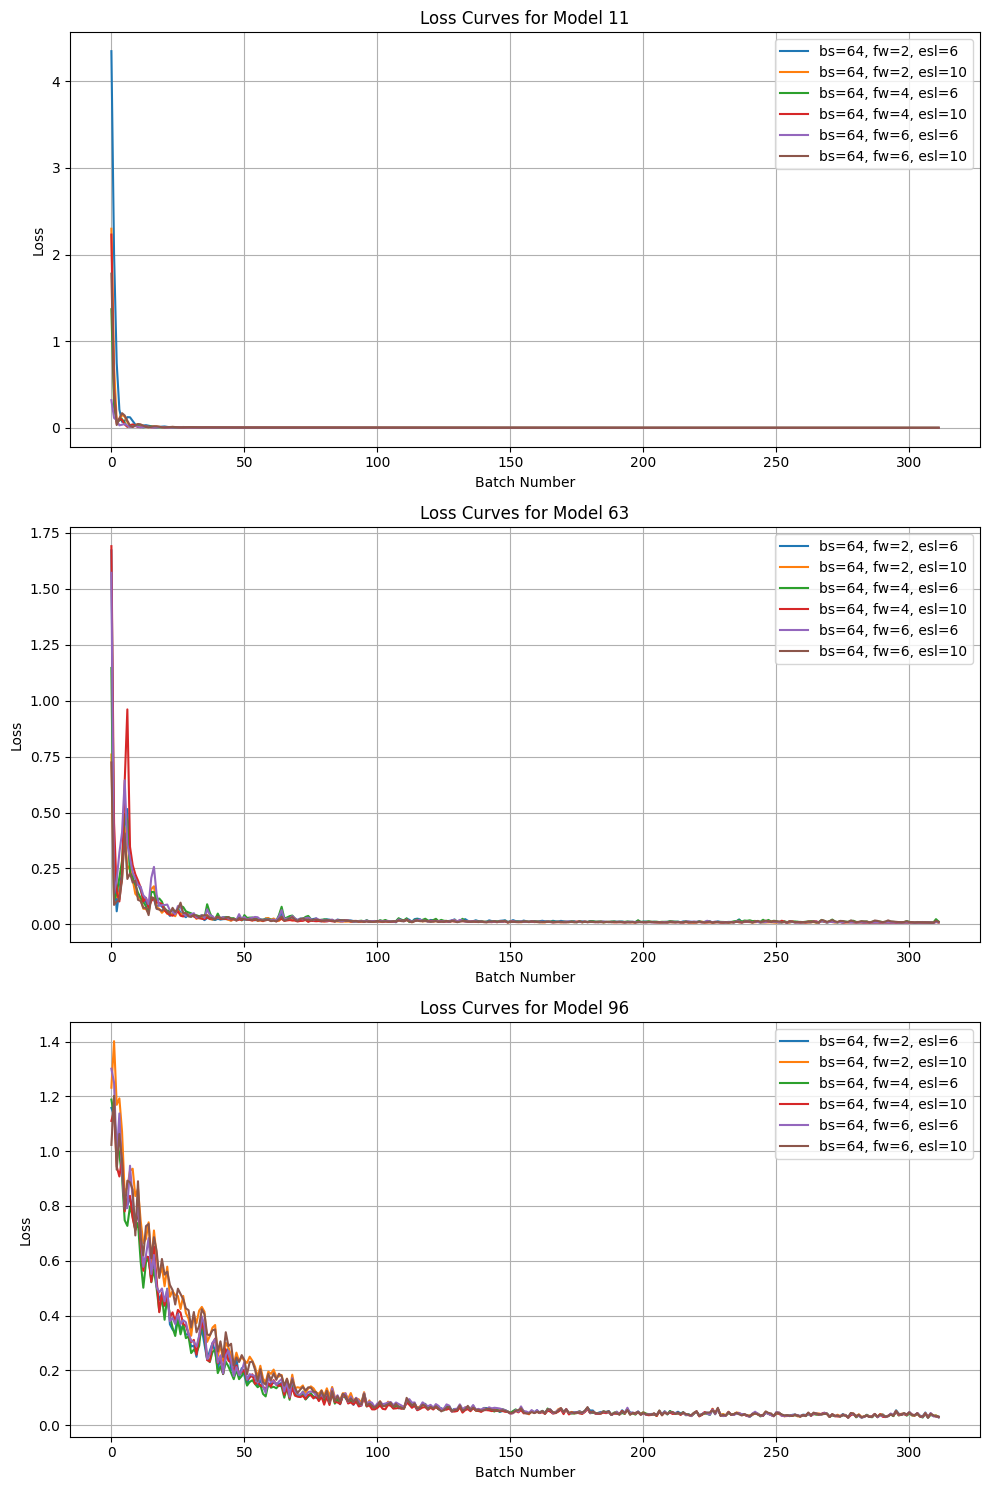

11

Evaluating model number 11...
Best hyperparameters for model 11: {'batch_size': 64, 'forecast_window': 6, 'enc_seq_len': 6, 'window_size': 12}
Detected constant function, using specialized prediction approach


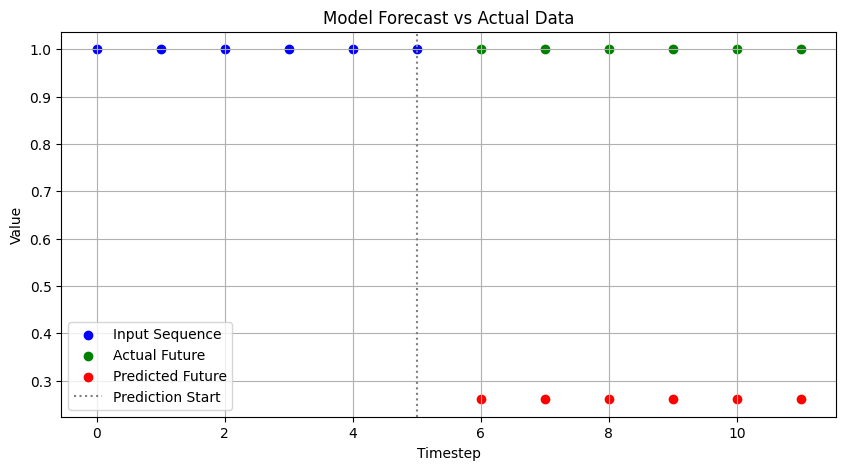

Input mean: 1.0000, std: 0.0000
Target mean: 1.0000, std: 0.0000
Prediction mean: 0.2607, std: 0.0000
Mean absolute error: 0.7393
63

Evaluating model number 63...
Best hyperparameters for model 63: {'batch_size': 64, 'forecast_window': 2, 'enc_seq_len': 10, 'window_size': 12}
Detected constant function, using specialized prediction approach


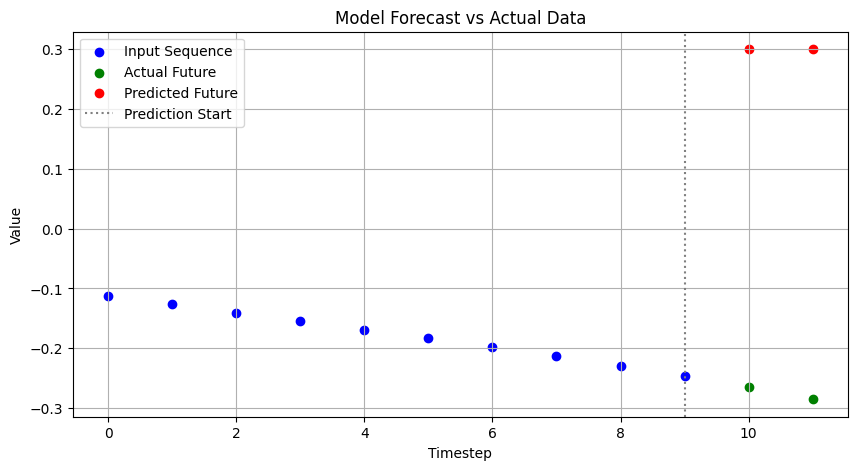

Input mean: -0.1775, std: 0.0425
Target mean: -0.2752, std: 0.0099
Prediction mean: 0.2998, std: 0.0000
Mean absolute error: 0.5750
96

Evaluating model number 96...
Best hyperparameters for model 96: {'batch_size': 64, 'forecast_window': 6, 'enc_seq_len': 6, 'window_size': 12}
Detected constant function, using specialized prediction approach


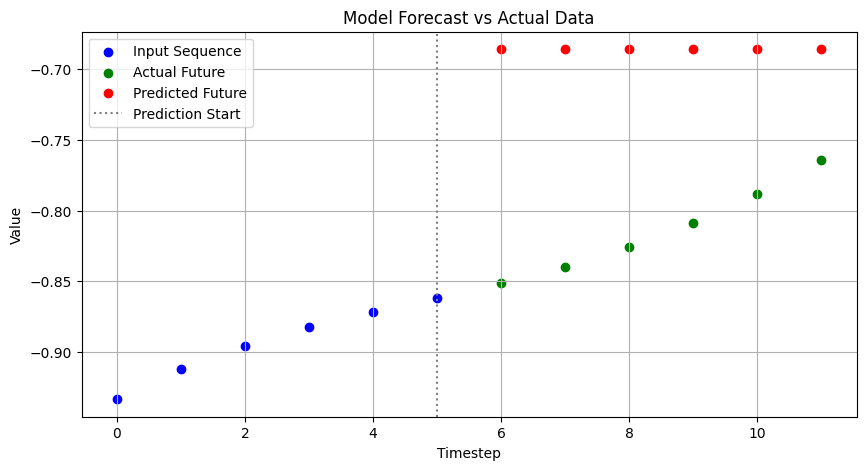

Input mean: -0.8928, std: 0.0244
Target mean: -0.8127, std: 0.0300
Prediction mean: -0.6857, std: 0.0000
Mean absolute error: 0.1270


In [8]:
# ----- Hyperparameter Grid -----
batch_sizes = [64]
forecast_windows = [2,4,6]
enc_seq_lens = [6,10]

# Compute window_size automatically
hyperparameter_grid = [
    (batch_size, forecast_window, enc_seq_len, enc_seq_len + forecast_window)
    for batch_size in batch_sizes
    for forecast_window in forecast_windows
    for enc_seq_len in enc_seq_lens
]

# ----- Fixed Parameters -----
step_size = 5
epochs = 1
batch_first = True
target_col_name = 'x'
timestamp_col = "t"
exogenous_vars = ['y', 'z']
input_variables = [target_col_name] + exogenous_vars

# Data directory
data_dir = r"C:\Users\hecht\OneDrive - Universität Heidelberg\Dokumente\_Studium\_Master\_2. Semester\DSML\Final Project\DSML_Final_Project\Datafiles"

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Run training across multiple hyperparameter combinations
train_multiple_hyperparameters([11, 63, 96], hyperparameter_grid, data_dir, batch_first, step_size, device, epochs)

# Iterate over both model numbers
for model_number in [11, 63, 96]:
    print(model_number)
    print(f"\nEvaluating model number {model_number}...")

    # Load test dataset (assuming it exists)
    test_file_path = os.path.join(data_dir, f"lorenz{model_number}_test.npy")

    if not os.path.exists(test_file_path):
        print(f"Skipping model {model_number}, test file not found: {test_file_path}")
        continue

    test_data = np.load(test_file_path)

    # Get best model and hyperparameters for this model
    if model_number not in best_results_by_file:
        print(f"No best hyperparameters found for model {model_number}, skipping...")
        continue

    best_hyperparams, _, _ = best_results_by_file[model_number]
    print(f"Best hyperparameters for model {model_number}: {best_hyperparams}")

    # Re-initialize the model with the best hyperparameters
    best_model = TimeSeriesTransformer(
        input_size=test_data.shape[1],
        dec_seq_len=best_hyperparams['forecast_window'],
        batch_first=batch_first,
        num_predicted_features=test_data.shape[1]
    ).to(device)

    # Run test evaluation
    test_model_prediction_modified(
        best_model, 
        test_data, 
        enc_seq_len=best_hyperparams['enc_seq_len'], 
        forecast_window=best_hyperparams['forecast_window'], 
        device=device,
        batch_first=batch_first
    )


Both the 63 and the 96 models are trained multiple times by the same routine, so that multiple combinations of hyperparameters can be compared. The architecture parameters were adjusted by hand and the so far best configuration can be seen in the class Transformer Timeseries. For Testing, I introduced the arbitrarily named 11 model, that is just a constant function at 1, as well as a random prediction taken from the sequence. This is always bad, because the model averages over a lot of different sequences. It cannot find for some reason the constant value, which is concerning. This is probably a vanishing gradient. I could not solve this in time. 

# Function for training both models on their best hyperparameters from the gridsearch

In [9]:
def train_final_model(best_results_by_file, model_number, epochs=10):
    """
    Trains a model using the best hyperparameters for each dataset.
    
    Args:
        best_results_by_file (dict): Dictionary containing best hyperparameters per dataset.
        model_number (int): The model number (e.g., 63 or 96) to choose the corresponding dataset.
        epochs (int): Number of training epochs.
    """
    trained_model = {}
    
    # Construct the training and test file paths based on the model_number
    train_file = os.path.join(data_dir, f"lorenz{model_number}_on0.05_train.npy")
    
    # Check if the training file exists
    if not os.path.exists(train_file):
        raise FileNotFoundError(f"Training file '{train_file}' not found. Ensure the file exists in the specified data directory.")
    
    # Load the training data
    train_data = np.load(train_file)

    # Get input size and best hyperparameters from best_results_by_file
    input_size = train_data.shape[1]
      
    if model_number not in best_results_by_file:
        raise KeyError(f"Hyperparameters for '{model_number}' not found in best_results_by_file.")
    
    best_hyperparams, _, _ = best_results_by_file[model_number]  # Use the base file name here
    forecast_window = best_hyperparams['forecast_window']
    enc_seq_len = best_hyperparams['enc_seq_len']
    window_size = best_hyperparams['window_size']
    
    print(f"\nTraining final model for model {model_number} with forecast_window={forecast_window}...")
    print(f"Training model: enc_seq_len={enc_seq_len}, window_size={window_size}")
    
    # Prepare training indices once before training
    training_indices = get_indices_entire_sequence(train_data, window_size, step_size=1)
    if len(training_indices) == 0:
        print(f"Skipping model due to no valid training indices.")
        return trained_model
    
    # Create dataset for training
    training_data = TransformerDataset(
        data=torch.tensor(train_data).float(),
        indices=training_indices,
        enc_seq_len=enc_seq_len,
        dec_seq_len=forecast_window,
        target_seq_len=forecast_window
    )
    
    # Create DataLoader for batching (only once)
    training_dataloader = DataLoader(training_data, batch_size=best_hyperparams['batch_size'], drop_last=True)
    
    # Define the model, optimizer, and loss function (initialize outside the loop)
    model = TimeSeriesTransformer(
        input_size=input_size,
        dec_seq_len=forecast_window,
        batch_first=True,
        num_predicted_features=input_size
    ).to(device)
    
    criterion = nn.MSELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Precompute masks once per epoch instead of each batch
    mask_enc = generate_square_subsequent_mask(forecast_window, enc_seq_len).to(device)
    mask_dec = generate_square_subsequent_mask(forecast_window, forecast_window).to(device)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        
        for src, tgt, tgt_y in training_dataloader:
            src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
            
            # Zero gradients, perform forward pass, calculate loss, and backpropagate
            optimizer.zero_grad()
            prediction = model(src, tgt, mask_enc, mask_dec)
            loss = criterion(tgt_y, prediction)
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else float('inf')
        print(f"Epoch {epoch+1}/{epochs} - model loss: {avg_epoch_loss:.8f}")
    
    trained_model = model  # Save the trained model
    print(f"Final training complete for model {model_number}.")

    return trained_model


# Functions for Generating a timeseries with the best models and evaluate on the psd

In [10]:
def sample_initial_condition(model_number, sequence_length):
    """
    Samples a random initial condition from the dataset.
    
    Args:
        model_number (int): The model number (e.g., 63 or 96) to choose the corresponding dataset.
        sequence_length (int): The length of the input sequence for the model.
    
    Returns:
        torch.Tensor: Randomly sampled initial input sequence.
    """
    # Construct the file name based on the model_number
    test_file = os.path.join(data_dir, f"lorenz{model_number}_test.npy")
    
    # Load the test data
    data = np.load(test_file)
    
    # Sample a random initial condition
    start_idx = np.random.randint(0, data.shape[0] - sequence_length)
    initial_condition = data[start_idx:start_idx + sequence_length]
    
    return torch.tensor(initial_condition).float().unsqueeze(0), start_idx


def predict_lorenz_system(model, model_number, initial_input, timesteps=100000):
    """
    Uses the trained model to predict a long time series of the Lorenz system.
    
    Args:
        model: Trained time series transformer model.
        model_number (int): Model number to locate the test data (e.g., 63 or 96).
        initial_input (torch.Tensor): Initial input sequence to start prediction.
        timesteps (int): Number of time steps to predict.
    
    Returns:
        np.array: Predicted time series data.
    """
    # Ensure model is in evaluation mode
    model.eval()
    predicted_series = []
    current_input = initial_input.to(device)
    
    # Load the test data to get the sequence length (model number)
    test_file = os.path.join(data_dir, f"lorenz{model_number}_test.npy")
    
    # The total length of the time series we're predicting
    # total_length = timesteps + initial_input.shape[1]  # Add initial input length to total length
    
    with torch.no_grad():
        # We need to predict the entire time series
        for _ in range(timesteps):
            # Generate masks for encoder and decoder
            mask_enc = generate_square_subsequent_mask(current_input.shape[1], current_input.shape[1]).to(device)
            mask_dec = generate_square_subsequent_mask(current_input.shape[1], current_input.shape[1]).to(device)
            
            # Predict the next timestep
            prediction = model(current_input, current_input, mask_enc, mask_dec)
            
            # Append the predicted value (last output) to the predicted series
            predicted_series.append(prediction[:, -1, :].cpu().numpy())  # Get only the last timestep in the batch

            # Update the input sequence: drop the first timestep and append the prediction as the new input
            current_input = torch.cat([current_input[:, 1:, :], prediction[:, -1:, :]], dim=1)
    
    # Convert the predicted series to a numpy array
    predicted_series = np.concatenate(predicted_series, axis=0)
    
    return predicted_series

# Function to extract corresponding true series from test data
def extract_true_series(model_number, start_idx, sequence_length):
    """
    Extract the corresponding true series from the test data starting from the initial condition.
    
    Args:
        model_number (int): The model number (e.g., 63 or 96) to choose the corresponding dataset.
        start_idx (int): The index from which to extract the series.
        sequence_length (int): The length of the sequence to extract.
    
    Returns:
        np.ndarray: True time series from the test data.
    """
    test_file = os.path.join(data_dir, f"lorenz{model_number}_test.npy")
    data = np.load(test_file)
    
    # Extract the corresponding true series starting from the start_idx
    return data[start_idx:start_idx + sequence_length]


# Function to compute the power spectrum error between predicted and true series
def evaluate_power_spectrum_error(model, model_number, sequence_length, timesteps=100000):
    # Sample the initial condition from the test data
    initial_input, start_idx = sample_initial_condition(model_number, sequence_length)
    
    # Extract the true series from the test data starting from the same initial condition
    true_series = extract_true_series(model_number, start_idx, timesteps)
    
    # Predict the series using the trained model
    predicted_series = predict_lorenz_system(model, model_number, initial_input, timesteps)
    
    # Compute the power spectrum error between the predicted and true series
    # Add the extra dimension for N_trajectories (set to 1)
    x_true_reshaped = np.expand_dims(true_series, axis=1)  # Shape becomes (1000, 1, 3)
    x_gen_reshaped = np.expand_dims(predicted_series, axis=1)    # Shape becomes (1000, 1, 3)
    error = psd.power_spectrum_error(x_true_reshaped, x_gen_reshaped)
    
    return error
    
def plot_predicted_vs_true_series(model_number, true_series, predicted_series):
    """
    Plots the predicted and true series for the Lorenz system.
    
    Args:
        model_number (int): The model number (e.g., 63 or 96) to choose the corresponding dataset.
        true_series (np.ndarray): True time series data.
        predicted_series (np.ndarray): Predicted time series data.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(true_series[:, 0], label="True Series (x)")
    plt.plot(predicted_series[:, 0], label="Predicted Series (x)")
    plt.plot(true_series[:, 1], label="True Series (y)")
    plt.plot(predicted_series[:, 1], label="Predicted Series (y)")
    plt.plot(true_series[:, 2], label="True Series (z)")
    plt.plot(predicted_series[:, 2], label="Predicted Series (z)")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.title(f"Model {model_number}: True vs. Predicted Series")
    plt.legend()
    plt.grid(True)
    plt.show()

# Final training of the best models

In [11]:
# train the final model for both model numbers and save the trained models

epochs = 10  # Number of epochs for training the final model

trained_models = {}
for model_number in [63, 96]:
    trained_model = train_final_model(best_results_by_file, model_number, epochs)
    trained_models[model_number] = trained_model


Training final model for model 63 with forecast_window=2...
Training model: enc_seq_len=10, window_size=12
From get_src_trg: data size = torch.Size([100000, 3])
Epoch 1/10 - model loss: 0.01766453
Epoch 2/10 - model loss: 0.00859104
Epoch 3/10 - model loss: 0.00684221
Epoch 4/10 - model loss: 0.00620503
Epoch 5/10 - model loss: 0.00591457
Epoch 6/10 - model loss: 0.00545785
Epoch 7/10 - model loss: 0.00542593
Epoch 8/10 - model loss: 0.00504870
Epoch 9/10 - model loss: 0.00498871
Epoch 10/10 - model loss: 0.00486594
Final training complete for model 63.

Training final model for model 96 with forecast_window=6...
Training model: enc_seq_len=6, window_size=12
From get_src_trg: data size = torch.Size([100000, 20])
Epoch 1/10 - model loss: 0.07851243
Epoch 2/10 - model loss: 0.02098158
Epoch 3/10 - model loss: 0.01479585
Epoch 4/10 - model loss: 0.01085352
Epoch 5/10 - model loss: 0.00946680
Epoch 6/10 - model loss: 0.00893784
Epoch 7/10 - model loss: 0.00863708
Epoch 8/10 - model loss: 

The best configurations found by the hyperparameter gridsearch are finally trained for more epochs in order to perform the final evaluation. The loss is quite low, considering we are dealing with a noisy system that is chaotic. Lets look how well the models can synthesize a timeseries. 

# Final Evaluation


Processing model 63
Initial input shape for model 63: torch.Size([1, 12, 3])
Predicted series shape for model 63: (1000, 3)
True series shape for model 63: (1000, 3)
Power spectrum error for model 63: 0.6804354687076816


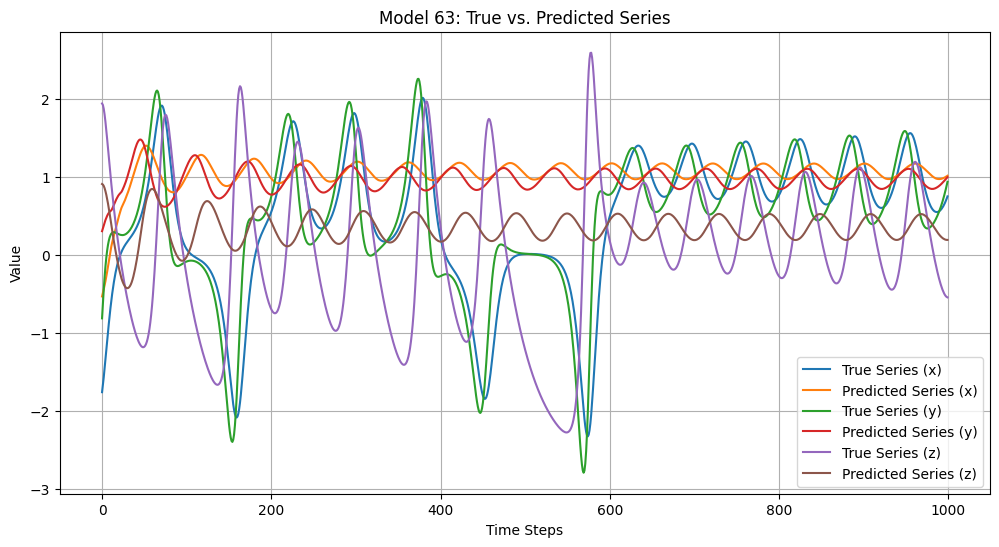


Processing model 96
Initial input shape for model 96: torch.Size([1, 12, 20])
Predicted series shape for model 96: (1000, 20)
True series shape for model 96: (1000, 20)
Power spectrum error for model 96: 0.5976775487571748


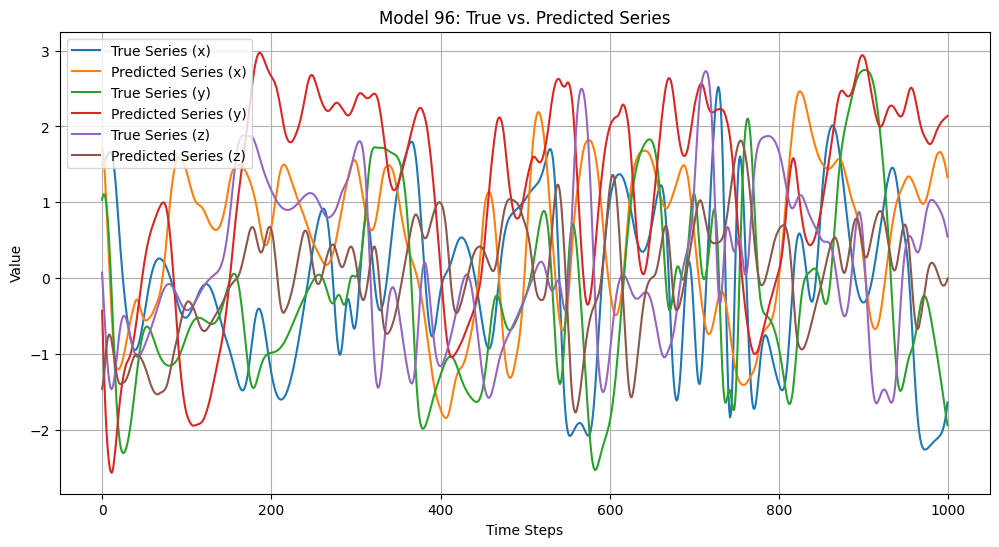

In [13]:
# Set hyperparameters for the final model evaluation
# sequence_length = 100  # Set the sequence length
timesteps = 1000  # Length of the prediction

import importlib

# Reload the module to ensure you get the latest version of the script.
importlib.reload(psd)

for model_number in [63, 96]:  # Iterate over model numbers
    print(f"\nProcessing model {model_number}")
    
    # Get sequence length for initial condition sampling
    best_hyperparams, _, _ = best_results_by_file[model_number]
    sequence_length = best_hyperparams['window_size']  
    
    # Sample the initial condition and predict the series
    initial_input, start_idx = sample_initial_condition(model_number, sequence_length)
    print(f"Initial input shape for model {model_number}: {initial_input.shape}")

    # Predict the series using the trained model
    predicted_series = predict_lorenz_system(trained_models[model_number], model_number, initial_input, timesteps)
    print(f"Predicted series shape for model {model_number}: {predicted_series.shape}")

    # Extract the true series from the test data
    true_series = extract_true_series(model_number, start_idx, timesteps)
    print(f"True series shape for model {model_number}: {true_series.shape}")

    # Compute the power spectrum error between the predicted and true series
    
    error = evaluate_power_spectrum_error(trained_models[model_number], model_number, sequence_length, timesteps)
    print(f"Power spectrum error for model {model_number}: {error}")

    # Plot the predicted and true series only for the 63 model for now
    plot_predicted_vs_true_series(model_number, true_series, predicted_series)
   
    

The generated sequence is given the same initial condition as the groundtruth data is starting from. So ideally they would coincide exactly. 
The powerspectrum distance measure was implemented. 
The reconstruction is not succesful. This could be due to various reasons (reason 1 is probably the most impactful here).

1. **Overfitting or Underfitting Model:**
   - **Overfitting** happens when the model learns the training data too well, capturing noise and small fluctuations that don't generalize well to new data. This can cause the generated sequence to deviate from the ground truth after a few steps.
   - **Underfitting**, on the other hand, occurs when the model is too simple to capture the underlying patterns in the data. As a result, the model won't perform well even on the training data, leading to a poor fit and larger discrepancies with the ground truth.

2. **Noise in the Training Data:**
   - Noise can distort the patterns that the model should learn, leading to inconsistencies in the predictions. Even small errors or fluctuations in the training data can result in significant deviations in the generated sequence as the model may misinterpret the noise.

3. **Chaotic Nature of the Groundtruth Data:**
   - Systems like the Lorenz system are highly sensitive to initial conditions, and small variations can lead to drastically different results over time. Even though the model starts with the same initial conditions as the ground truth, the chaotic nature of the data can lead to diverging trajectories over time. Here it seems less likely, because the reconstrucion is not fluctuating wildly, it is rather oscillating, which is not complex enough for reconstruction.

These challenges highlight the complexities of modeling chaotic systems or time series data. To mitigate some of these issues, the following approaches can be useful:

- **Regularization Techniques:** Using regularization methods like dropout or L2 regularization to prevent overfitting.
- **Improved Initialization:** For chaotic systems, starting from multiple initial conditions or using techniques like ensemble methods can sometimes help to stabilize predictions.
